<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/Chapter6_Species_Distribution_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6장. 종 분포 모델링: GEE를 활용한 서식지 예측 및 분석

## 6.1. 종 분포 모델 소개

### 6.1.1. 종 분포 모델이란?

종 분포 모델링(SDM: Species Distribution Modeling)은 종의 실제 또는 잠재적인 지리적 분포를 추정하는 가장 일반적인 방법론으로 해당 종에 적합한 환경 조건을 특성화하고, 그런 다음 어느 지역에 이러한 적합한 환경이 분포되어 있는지 식별하는 것입니다.

SDM은 최근 수년간 보전계획의 중요한 구성요소로 부상하였으며, 이를 위해 다양한 모델링 기법이 개발되어 왔습니다. Google Earth Engine에서 SDM을 구현하면 대규모 환경 데이터에 쉽게 접근할 수 있고, 강력한 컴퓨팅 능력과 머신러닝 알고리즘 지원으로 신속한 모델링이 가능해집니다. 이번 장에서는 Google Earth Engine을 활용하여 종 분포 모델링을 구현해 보겠습니다.

### 6.1.2. 모델에 필요한 데이터

SDM은 일반적으로 알려진 종의 위치 기록과 환경변수 간의 관계를 활용하여 모집단이 유지될 수 있는 환경 조건을 식별합니다. 즉, 두 가지 유형의 모델 입력 데이터가 필요합니다: 1) 알려진 종의 위치 기록; 그리고 2) 다양한 환경변수. 이러한 데이터는 알고리즘에 입력되어 종의 출현과 관련된 환경조건을 식별하는데 사용됩니다.

### 6.1.3. 종 분포 모델링의 작업 흐름

보전생물학자인 Dr. Ramiro D. Crego는 GEE JavaScript Code Editor를 통해 종 분포 모델링을 구현하고, 그 연구결과를 공개했습니다. 이 책에서 소개할 SDM의 작업 흐름은 그가 공유한 [JavaScript 소스코드](https://smithsonian.github.io/SDMinGEE/)를 Python 언어로 변환 및 수정 보완한 것입니다.

이 책에서 다루는 Google Earth Engine을 이용한 종 분포 모델링의 작업 흐름은 다음과 같습니다: 1) 종 출현 데이터 수집 및 처리, 2) 관심 영역 정의, 3) GEE 환경 변수 추가, 4) 임의-비출현 데이터 생성, 5) 모델 적합 및 예측, 6) 변수 중요도 및 정확도 평가.

<p align="center"><img src="https://github.com/osgeokr/GEE-PAM-Book/blob/main/img/sdm_workflow.png?raw=1" width = "800px"></img></p>

## 6.2. GEE를 활용한 서식지 예측 및 분석

GEE 기반 종 분포 모델링은 "팔색조(Pitta nympha)"를 사례로 정리해 보겠습니다. 팔색조는 우리나라에서는 드문 여름철새이자 나그네새로, 최근 한반도의 기후 온난화 등으로 인해 분포 지역이 확대되고 있습니다. 팔색조는 희귀종으로 멸종위기 야생생물 Ⅱ급, 천연기념물 제204호, 국가적색목록 평가: 지역절멸(RE) 및 IUCN 범주: 취약(VU) 등급 종입니다.

팔색조의 보전계획 수립을 위한 SDM은 충분히 가치있어 보입니다. 이제 GEE를 통해 서식지 예측 및 분석을 진행해 보겠습니다.

실습에 앞서 몇 가지 Python 라이브러리를 추가 설치합니다. 이 명령은 해당 라이브러리를 업그레이드(`-U`)하면서 설치합니다. `-q` 옵션은 설치 과정에서의 상세한 메시지를 출력하지 않도록 하는 '조용한(quiet)' 모드입니다. 만약 Google Colab에서 실습을 진행한다면 `pycrs`만 추가 설치해 주시면 됩니다.

In [ ]:
# 라이브러리 설치
# %pip install -U -q pyarrow
# %pip install -U -q geopandas
# %pip install -U -q statsmodels
%pip install -U -q pycrs

  Preparing metadata (setup.py) ... done


Python 라이브러리들을 호출합니다. import 문은 모듈의 전체 내용을 가져오고, from import 문은 모듈에서 특정 객체만 가져올 수 있습니다.

In [1]:
# 라이브러리 호출
import ee
import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence import variance_inflation_factor

Google Earth Engine의 API(ee 라이브러리)를 인증 및 초기화합니다.

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-foss4g')

###  6.2.1. 종 출현 데이터 수집 및 처리

이제 팔색조의 종 출현 데이터를 수집해 보겠습니다. 현재 관심 종의 출현 데이터를 가지고 있지 않더라도, 생물다양성 정보를 제공하는 GBIF API를 통해 특정 생물종에 관한 관측 데이터를 확보할 수 있습니다.

GBIF는 Global Biodiversity Information Facility의 약자로, 전 세계 생물 다양성 정보를 관리하는 국제적인 기구입니다. 과학 연구, 환경 보호 및 정책 결정에 도움을 주는 생물종 분포 데이터를 제공하는 중요한 역할을 합니다. [GBIF API](https://techdocs.gbif.org/en/openapi/)는 GBIF에서 제공하는 생물종 분포 데이터에 접근할 수 있는 API로,  이를 활용하면 데이터를 검색, 필터링 및 다운로드할 수 있으며 생물종과 관련된 다양한 정보를 얻을 수 있습니다.

아래 코드에서 변수 species_name은 팔색조의 학명을, country_code 변수는 대한민국의 국가코드를 할당했습니다. base_url 변수에는 GBIF API 주소가 저장됩니다. params는 API 요청에 사용될 파라미터들을 담고 있는 딕셔너리입니다.

* scientificName: 검색 대상 종의 학명을 설정합니다.
* country_code:  검색을 특정 국가로 한정합니다.
* hasCoordinate: 좌표가 있는 데이터만(true) 검색하도록 합니다.
* basisOfRecord": 인간에 의한 관측(HUMAN_OBSERVATION) 기록만 택합니다.
* limit: 최대 10,000개의 결과를 반환하도록 설정합니다.

In [3]:
def get_gbif_species_data(species_name, country_code="KR"):
    """
    GBIF API를 활용하여 특정 생물종의 관측 데이터를 조회하고 데이터프레임으로 반환합니다.

    Parameters:
    species_name (str): 조회할 생물종의 학명.
    country_code (str): 관측 데이터를 조회할 국가의 코드 (기본값: "KR").

    Returns:
    pd.DataFrame: 관측 데이터를 포함하는 pandas 데이터프레임.
    """
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "country": country_code,
        "hasCoordinate": "true",
        "basisOfRecord": "HUMAN_OBSERVATION",
        "limit": 10000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # 응답 에러가 있을 경우 예외를 발생시킵니다.
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:  # 데이터가 있는 경우
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()  # 비어있는 데이터프레임 반환
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # 예외 발생 시 비어있는 데이터프레임 반환

In [4]:
# 예제 사용
df = get_gbif_species_data("Pitta nympha")
print(df.head())

          key                            datasetKey  \
0  4126765284  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1  4129762646  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2  4133941545  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3  4420828662  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4  4421116118  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                       publishingOrgKey                       installationKey  \
0  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
1  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
2  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
3  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
4  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   

                 hostingOrganizationKey publishingCountry     protocol  \
0  28eb1a3f-1c15-4a95-931a-4af90ecb574d                US  DWC_ARCHIVE   
1  28eb1a3f-1c15-4a95-931a-4af90ec

In [ ]:
# GBIF API 파라미터 설정
species_name = "Pitta nympha" # 학명
country_code = "KR" # 국가코드
base_url = "https://api.gbif.org/v1/occurrence/search"
params = {
    "scientificName": species_name, # 학명
    "country": country_code, # 국가
    "hasCoordinate": "true", # 좌표 유무
    "basisOfRecord": "HUMAN_OBSERVATION", # 인간에 의한 관측
    "limit": 10000, # 최대 10,000개 결과 반환
}

앞서 설정한 파라미터를 사용하여 GBIF API를 통해 팔색조(Pitta nympha)의 관측기록을 조회하고, 조회된 결과를 DataFrame으로 불러와 첫 번째 행을 확인해 봅니다. DataFrame은 테이블 형식의 데이터를 다루기 위한 데이터 구조로 행과 열로 이루어져 있습니다.

In [ ]:
# GBIF API 호출
response = requests.get(base_url, params=params)
data = response.json() # dict
occurrences = data["results"] # list

# List를 DataFrame으로 변환
df = pd.json_normalize(occurrences)
df.head(1)

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,behavior,verbatimElevation,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4126765284,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-01-23T16:28:21.693+00:00,2024-01-25T09:13:47.069+00:00,431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


필요하다면 DataFrame을 CSV 파일로 저장하고 다시 읽어올 수도 있습니다.

In [ ]:
# DataFrame을 CSV로 저장
df.to_csv("pitta_nympha_data.csv", index=False)
df = pd.read_csv("pitta_nympha_data.csv")
df.head(1)

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,behavior,verbatimElevation,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4126765284,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-01-23T16:28:21.693+00:00,2024-01-25T09:13:47.069+00:00,431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


이번에는 DataFrame을 지리정보를 포함하는 열(geometry)을 가진 GeoDataFrame으로 변환하고 첫번째 행을 확인해 봅니다.

In [ ]:
# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]
gdf.head(1)

,species,year,month,geometry
0,Pitta nympha,2023,5,POINT (126.72514 33.20314)


GeoDataFrame은 GeoPackage 파일로 저장하고 다시 읽어올 수 있습니다. GeoPackage (*.gpkg) 파일은 QGIS와 같은 지리공간 소프트웨어에서도 사용 가능합니다.

In [ ]:
# GeoDataFrame을 GeoPackage로 변환
gdf.to_file("pitta_nympha_data.gpkg", driver="GPKG")
gdf = gpd.read_file("pitta_nympha_data.gpkg")
gdf.head(1)

,species,year,month,geometry
0,Pitta nympha,2023,5,POINT (126.72514 33.20314)


이번에는 GeoDataFrame에서 연도(year)와 월별(month) 데이터 분포를 시각화하여 그래프로 표시하고, 그래프를 이미지 파일로 저장하는 함수를 만들었습니다. 이렇게 하면 종 출현 데이터의 시계열 패턴 및 계절적 변동을 파악할 수 있으며, 데이터의 이상치나 품질 문제를 신속하게 확인할 수 있습니다.

In [ ]:
# 연도(year)와 월별(month) 데이터 분포 시각화
def plot_data_distribution(gdf, h_size=12):

    plt.figure(figsize=(h_size, h_size-8))

    # 연도별 데이터 분포 그래프 (왼쪽)
    plt.subplot(1, 2, 1)
    year_counts = gdf['year'].value_counts().sort_index()
    plt.bar(year_counts.index, year_counts.values)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Yearly Data Distribution')

    # 막대 그래프 위에 데이터 개수 표시
    for i, count in enumerate(year_counts.values):
        plt.text(year_counts.index[i], count, str(count), ha='center', va='bottom')

    # 월별 데이터 분포 그래프 (오른쪽)
    plt.subplot(1, 2, 2)
    month_counts = gdf['month'].value_counts().sort_index()
    plt.bar(month_counts.index, month_counts.values)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Monthly Data Distribution')

    # 막대 그래프 위에 데이터 개수 표시
    for i, count in enumerate(month_counts.values):
        plt.text(month_counts.index[i], count, str(count), ha='center', va='bottom')

    # x 축의 눈금을 정수 형식으로 설정
    plt.xticks(month_counts.index, map(int, month_counts.index))

    # 그래프 출력
    plt.tight_layout()
    plt.savefig('data_distribution_plot.png')
    plt.show()

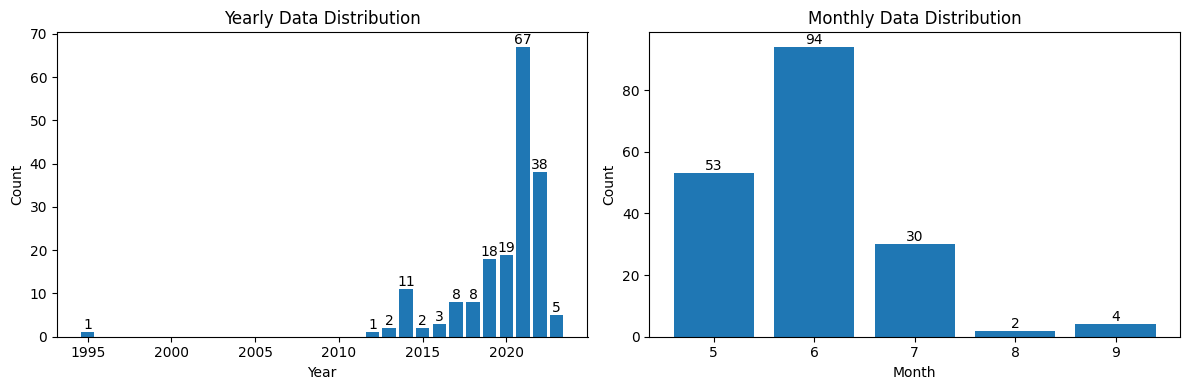

In [ ]:
plot_data_distribution(gdf)

1995년 데이터는 표본이 매우 적고 다른 연도의 데이터와의 간격이 크며, 8월과 9월도 표본이 적고 계절적 특성이 다른 시기의 데이터입니다. 이를 제외하는 것은 모델의 안정성과 예측력을 향상시키는데 기여할 것입니다.

그러나 데이터를 제외하는 것이 모델의 일반화 능력을 향상시킬 수는 있지만, 연구 목적에 중요한 정보를 잃어버릴 수도 있기 때문에 이런 결정은 주의 깊게 이루어져야 합니다.

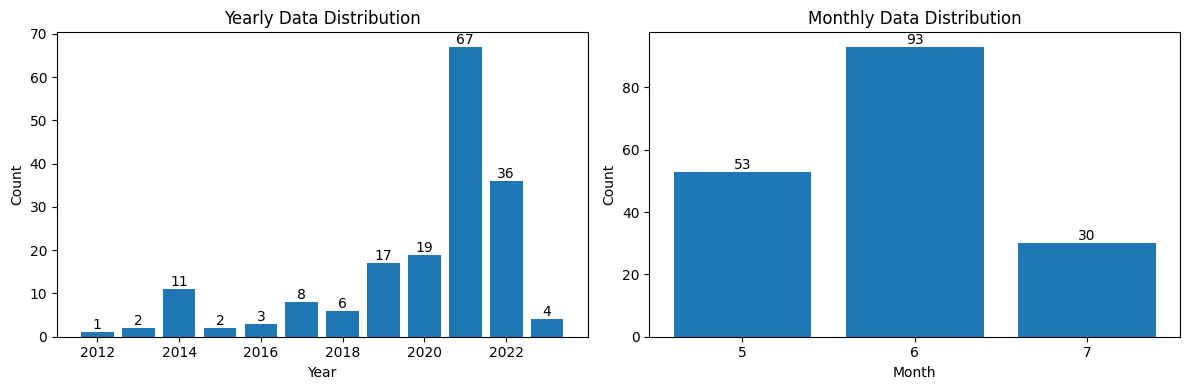

In [ ]:
# 연도와 월별 데이터 필터링
filtered_gdf = gdf[
    (~gdf['year'].eq(1995)) &
    (~gdf['month'].between(8, 9))
]

plot_data_distribution(filtered_gdf)

또한 히트맵(heatmap)을 사용하면 연도와 월별 종 출현 빈도를 한눈에 파악할 수 있으며, 데이터의 시간적 변화와 패턴을 직관적으로 시각화할 수 있습니다.

In [ ]:
# 연도(year)와 월별(month) 데이터 분포 히트맵
def plot_heatmap(gdf, h_size=8):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # 히트맵
    plt.figure(figsize=(h_size, h_size-6))
    heatmap = plt.imshow(statistics.values, cmap="YlOrBr", origin="upper", aspect="auto")

    # 각 픽셀 위에 수치 표시
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(j, i, statistics.values[i, j], ha="center", va="center", color="black")

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig('heatmap_plot.png')
    plt.show()
    print(gdf.groupby(["month", "year"]).size().unstack(fill_value=0))

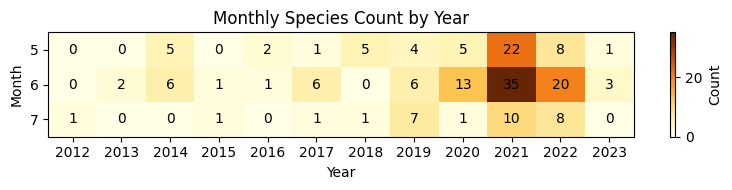

year   2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
month                                                                        
5         0     0     5     0     2     1     5     4     5    22     8     1
6         0     2     6     1     1     6     0     6    13    35    20     3
7         1     0     0     1     0     1     1     7     1    10     8     0


In [ ]:
plot_heatmap(filtered_gdf)

이제 필터링된 GeoDataFrame을 Google Earth Engine 객체로 변환합니다.

In [ ]:
# GeoDataFrame을 Earth Engine 객체로 변환
data_raw = geemap.geopandas_to_ee(filtered_gdf)

만약 필터링된 GeoDataFrame을 재사용 목적으로 Shapefile로 저장하고 GEE 객체로 변환한다면 아래 코드를 사용하시면 됩니다.

In [ ]:
# GeoDataFrame을 Shapefile로 저장
output_shapefile = 'pitta_nympha_data.shp'
filtered_gdf.to_file(output_shapefile)

# Shapefile을 GEE 객체로 변환
data_raw = geemap.shp_to_ee(output_shapefile)

이어서 종 분포 모델 결과의 래스터 픽셀 크기는 1km 해상도로 정의하겠습니다.

In [ ]:
# 공간 해상도 설정(m)
GrainSize = 1000

동일한 1km 해상도의 래스터 픽셀 내에 여러 개의 출현 지점이 있을 경우, 이들은 같은 지리적 위치에 있어 동일한 환경 조건을 공유할 가능성이 높습니다. 분석 시, 이러한 데이터를 그대로 사용하면 데이터로 인해 분석 결과에 편향이 발생할 수 있습니다.

즉, 지리적 샘플링 편향(geographic sampling bias)의 잠재적 영향을 제한해야 합니다. 각 1km 픽셀 내에서 하나의 위치만을 남겨 나머지는 모두 제거함으로써 모델이 환경 조건을 더 객관적으로 반영하도록 조정하겠습니다.

In [ ]:
def remove_duplicates(data, GrainSize):
    # 선택한 공간 해상도(1km)에서 픽셀 당 출현 기록 하나만 무작위 선택
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data), scale=10, geometries=True)
    return rand_point_vals.distinct('random')

Data = remove_duplicates(data_raw, GrainSize)

# 선택 전, 선택 후
print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 176
Final data size: 111


지리적 샘플링 편향의 전처리 전(파란색)과 후(빨간색)를 가시화한 결과는 다음과 같습니다. 두 개 레이어를 비교하기 쉽도록 팔색조 출현 좌표가 많은 [한라산국립공원](https://www.protectedplanet.net/10931)으로 지도를 이동했습니다.

In [ ]:
# 지리적 샘플링 편향의 전처리 전(파란색)과 후(빨간색) 가시화
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

Vworld_Base = TileLayer(
    url='https://xdworld.vworld.kr/2d/Base/service/{z}/{x}/{y}.png',
    name='Vworld Base',
    attribution='Vworld',
    shown=True
)
Map.add_layer(Vworld_Base)

# 한라산국립공원
wdpa_id = 10931
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
protected_area = wdpa.filter(ee.Filter.eq('WDPAID', wdpa_id))

Map.addLayer(data_raw, {'color': 'blue'}, 'Original data')
Map.addLayer(Data, {'color': 'red'}, 'Final data')
Map.centerObject(protected_area, 10)
Map

Map(center=[33.37412755796072, 126.54158272259407], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.2. 관심 영역 정의

"관심 영역(AOI: Area Of Interest)"는 연구자가 분석하려는 지리적 영역을 가리키는 용어입니다. 연구지역과 비슷한 의미를 가집니다.

여기서는 출현지점 레이어 지오메트리의 바운딩 박스(경계 상자)를 가져와서 그 주변에 50킬로미터 크기의 버퍼를 생성(최대 1,000미터의 오차 허용)하였습니다.

In [ ]:
# AOI 정의
AOI = Data.geometry().bounds().buffer(
    distance=50000, maxError=1000)

# 연구지역 경계를 지도에 추가
outline = ee.Image().byte().paint(
    featureCollection=AOI, color=1, width=3)

Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.3. GEE 환경변수 추가

이제 환경변수를 추가해 보겠습니다. GEE는 기온, 강수량, 고도, 수목 피복, 지형 등 다양한 환경변수에 대한 광범위한 데이터셋을 제공합니다. 이를 통해 팔색조의 서식지 선호도에 영향을 미치는 다양한 요인들을 종합적으로 분석할 수 있습니다.

SDM에서 GEE 환경변수의 선택은 해당 생물종의 서식지 선호도 특성을 반영해야 합니다. 이를 위해서는 팔색조의 이전 문헌 및 연구 고찰이 선행되어야 합니다. 이 글은 주로 튜토리얼에 초점을 맞추었기 때문에, 일부 심도 깊은 내용은 생략되었습니다.

**WorldClim V1 Bioclim**: 월별 기온과 강수량으로부터 파생된 19개 생물기후 변수(bioclimatic variables)들을 제공합니다. 1960년부터 1991년 사이의 평균 기온과 강수량으로 계산되었으며 해상도는 927.67 m입니다.

In [ ]:
# WorldClim V1 Bioclim
BIO = ee.Image("WORLDCLIM/V1/BIO")

**NASA SRTM Digital Elevation 30m**: 셔틀 레이더 지형 미션(SRTM: Shuttle Radar Topography Mission)의 디지털 고도 데이터로, 주로 2000년에 데이터를 수집했으며 1 아크초(대략 30m) 해상도로 제공됩니다. 아래 코드는 SRTM 데이터로부터 고도, 경사, 경사방향, 음영기복 레이어를 계산해줍니다.

In [ ]:
# NASA SRTM Digital Elevation 30m
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

**Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m**: Landsat 식생 연속 필드(VCF: Vegetation Continuous Fields) 수목 피복 레이어는 수목이 특정 높이(5m) 이상일 때 수직으로 투영된 식생 면적의 비율을 추정합니다. 이 데이터셋은 2000년, 2005년, 2010년, 2015년을 중심으로 한 네 시기에 대해 제공되며 해상도는 30m입니다. 여기서는 네 시기의 중간값을 택했습니다.

In [ ]:
# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
TCC = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
MedianTCC = TCC.filterDate('2000-01-01', '2015-12-31')
MedianTCC = MedianTCC.select(['tree_canopy_cover'], ['TCC']).median()

`BIO`(생물기후), `Terrain`(지형) 및 `MedianTCC`(수폭피복)를 하나의 다중 밴드 이미지로 결합합니다. `Terrain`에서 `elevation` 밴드를 선택하고, `elevation`이 0보다 큰 지점들로 구성된 마스크를 생성합니다. 즉, 해수면 이하의 지역(예: 바다)를 마스킹하고 분석을 관심 영역으로 제한합니다. 이로써 연구자는 AOI에 대한 다양한 환경적 요인들을 통합적으로 분석할 수 있는 준비를 마치게 됩니다.

In [ ]:
# 밴드들을 하나의 다중 밴드 이미지로 결합
predictors = BIO.addBands(Terrain).addBands(MedianTCC)

# 수역 마스크 생성
watermask =  Terrain.select('elevation').gt(0)

# 해양 픽셀 마스킹 및 관심 영역 클리핑
predictors = predictors.updateMask(watermask).clip(AOI)

상관관계가 높은 예측변수들을 함께 모델에 포함하면 **다중공선성(Multicollinearity)** 문제가 발생할 수 있습니다. 다중공선성은 모델 내에서 독립 변수들 간에 강한 선형 관계가 있을 때 발생하는 현상으로, 이로 인해 모델의 계수(가중치) 추정의 불안정성을 야기합니다. 이러한 불안정성은 모델의 신뢰도를 떨어뜨리며, 새로운 데이터에 대한 예측 또는 해석을 어렵게 만들 수 있습니다.

따라서, 다중공선성을 고려하여 예측변수를 선택하는 과정을 진행해 보겠습니다. 먼저 예측변수 이미지에서 임의로 5,000개 지점을 선택하고, 해당 지점에서 다중-밴드 예측 이미지의 예측변수 값을 추출합니다.

In [ ]:
# 임의로 5,000개 지점 생성
DataCor = predictors.sample(
    scale=GrainSize, numPixels=5000, geometries=True)
# 예측변수 값 추출
PixelVals = predictors.sampleRegions(
    collection=DataCor, scale=GrainSize, tileScale=16)

추출한 지점별 예측변수 값을 DataFrame으로 변환하여 첫번째 행을 확인해 봅니다.

In [ ]:
# 예측변수 값 ee를 df로 변환
PixelVals_df = geemap.ee_to_df(PixelVals)
PixelVals_df.head(1)

,TCC,aspect,bio01,bio02,bio03,bio04,bio05,bio06,bio07,bio08,...,bio13,bio14,bio15,bio16,bio17,bio18,bio19,elevation,hillshade,slope
0,9.0,288,140,89,26,8572,304,-26,330,246,...,215,32,63,561,111,539,111,28,187,2


In [ ]:
columns = PixelVals_df.columns
print(columns)

Index(['TCC', 'aspect', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06',
       'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14',
       'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'elevation', 'hillshade',
       'slope'],
      dtype='object')


**스피어만(Spearman) 상관계수**를 사용하여 주어진 예측 변수들 간의 상관관계를 계산하고, 이를 시각화한 히트맵을 출력해 봅니다.

In [ ]:
def plot_correlation_heatmap(dataframe, h_size=10):
    # 스피어만 상관계수 계산
    correlation_matrix = dataframe.corr(method="spearman")

    # 히트맵 그리기
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # 히트맵에 수치 표시
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                     ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables correlation matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

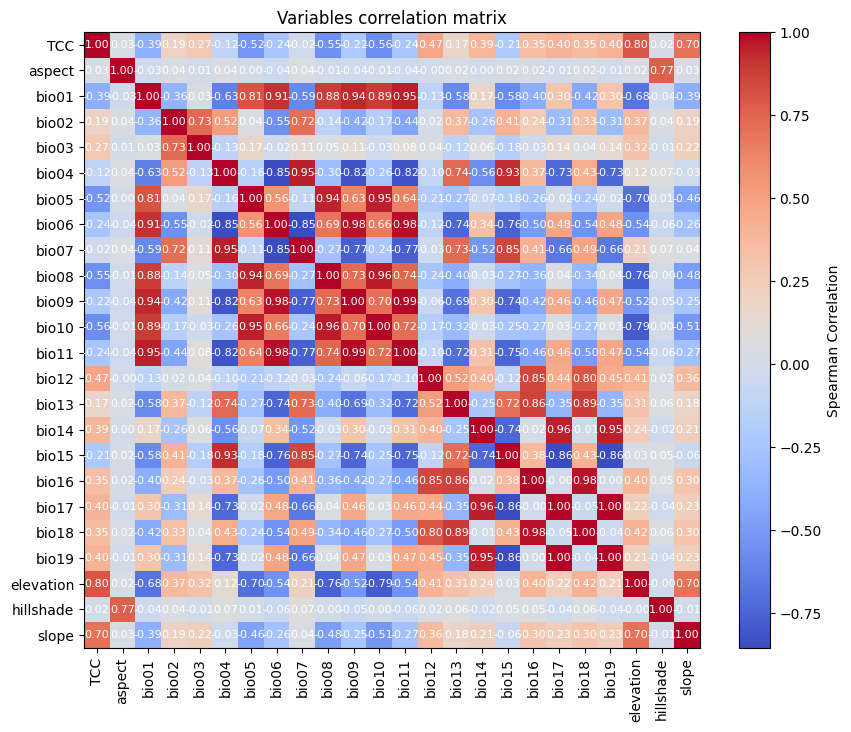

In [ ]:
# 변수 상관행렬 히트맵
plot_correlation_heatmap(PixelVals_df)

스피어만 상관계수는 예측변수 간의 일반적인 연관성을 파악하는 데 유용하지만, 복수의 변수가 서로 어떻게 상호작용하는지, 즉 다중공선성을 직접적으로 평가하지는 않습니다.

**분산팽창인자(VIF: Variance Inflation Factor)**는 다중공선성을 평가하고 변수를 선택 하는데 사용되는 통계적 지표입니다. 각 독립변수의 다른 독립변수에 대한 선형관계의 정도를 나타내며, 높은 VIF 값은 다중공선성의 증거일 수 있습니다.

일반적으로 VIF 값은 5또는 10보다 크면 해당 변수가 다른 변수들과 강한 상관관계를 가지며 모델의 안정성과 해석력을 저해할 가능성이 높다는 것을 나타냅니다. 여기서는 10보다 작은 값을 기준으로 변수를 선택했습니다.

In [ ]:
def filter_variables_by_vif(dataframe, threshold=10):

    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print('Bands:', bands)

    return filtered_data, bands

VIF를 통해 아래 6개 변수가 선택되었습니다.

In [ ]:
filtered_PixelVals_df, bands = filter_variables_by_vif(PixelVals_df)

Removing 'bio05' with VIF inf
Removing 'bio04' with VIF 183283.50
Removing 'bio10' with VIF 65619.17
Removing 'bio07' with VIF 47408.97
Removing 'bio17' with VIF 26161.26
Removing 'bio01' with VIF 9404.98
Removing 'bio16' with VIF 3787.52
Removing 'bio03' with VIF 2470.76
Removing 'bio18' with VIF 1768.74
Removing 'bio08' with VIF 1245.80
Removing 'bio06' with VIF 961.54
Removing 'bio12' with VIF 605.44
Removing 'bio19' with VIF 398.72
Removing 'bio15' with VIF 351.93
Removing 'hillshade' with VIF 130.18
Removing 'bio13' with VIF 47.19
Removing 'bio11' with VIF 31.25
Removing 'bio02' with VIF 13.91
Bands: ['TCC', 'aspect', 'bio09', 'bio14', 'elevation', 'slope']


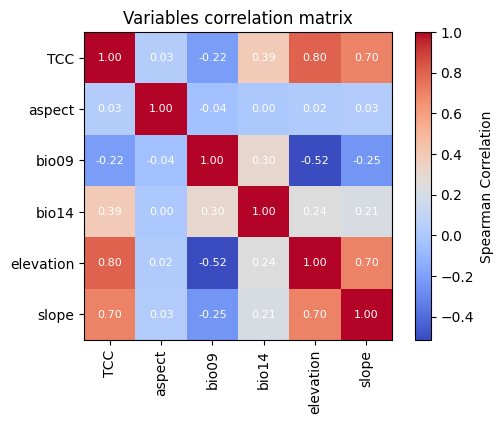

In [ ]:
predictors = predictors.select(bands)
plot_correlation_heatmap(filtered_PixelVals_df, h_size=6)

이어서 6개 예측변수를 지도화해 보겠습니다. 지도 가시화에 사용가능한 팔레트는 아래 코드로 호출해보실 수 있습니다.

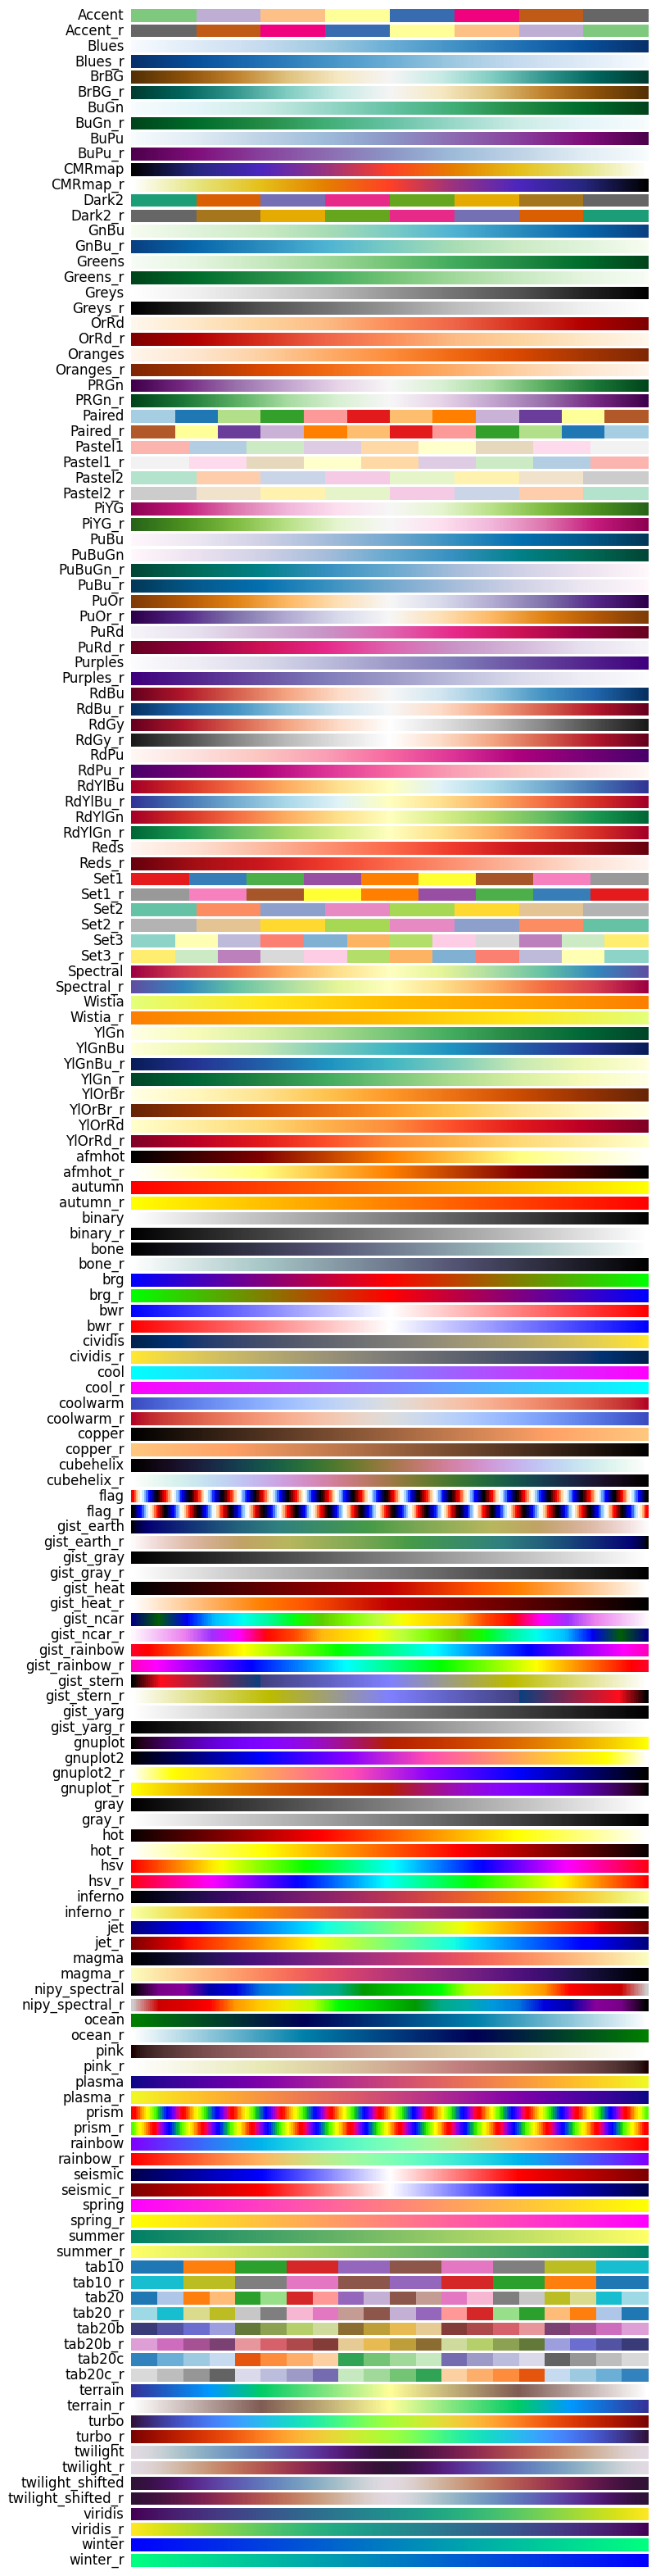

In [ ]:
cm.plot_colormaps(width=8.0, height=0.2)

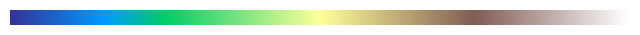

In [ ]:
cm.plot_colormap('terrain',
                 width=8.0, height=0.2, orientation='horizontal')

In [ ]:
# elevation (고도) 레이어
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['elevation'],
              'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)",
                 orientation="vertical", layer_name="elevation")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# bio09 최소값 & 최대값 계산
min_val = predictors.select("bio09").multiply(0.1). \
reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio09").multiply(0.1). \
reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

# bio09 (가장 건조한 분기의 평균 기온) 레이어
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'min': math.floor(min_val['bio09']), \
              'max': math.ceil(max_val['bio09']),
              'palette': cm.palettes.hot}
Map.addLayer(predictors.select("bio09").multiply(0.1),
             vis_params, 'bio09')
Map.add_colorbar(vis_params,
                 label="Mean temperature of driest quarter (℃)",
                 orientation="vertical", layer_name="bio09")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# slope (경사) 레이어
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# aspect (경사방향) 레이어
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# bio14 최소값 & 최대값 계산
min_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

# bio14 (가장 건조한 달의 강수량) 레이어
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)
vis_params = {'bands':['bio14'], 'min': math.floor(min_val['bio14']), 'max': math.ceil(max_val['bio14']), 'palette': cm.palettes.Blues}
Map.addLayer(predictors, vis_params, 'bio14')
Map.add_colorbar(vis_params, label="Precipitation of driest month (mm)", orientation="vertical", layer_name="bio14")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# TCC (수목피복) 레이어
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['TCC'], 'min': 0, 'max': 100,
              'palette':
               ['ffffff', 'afce56', '5f9c00', '0e6a00', '003800']}
Map.addLayer(predictors, vis_params, 'TCC')
Map.add_colorbar(vis_params, label="Tree Canopy Cover (%)",
                 orientation="vertical", layer_name="TCC")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.4. 임의-비출현 데이터 생성

종 분포 모델링 과정에서 생물종 입력 데이터 선정은 주로 두 가지 접근방식을 사용합니다:

* 출현-배경(Presence- Background) 방법: 특정 종이 관찰된 위치(출현)와 그 종이 관찰되지 않은 다른 위치(배경)을 비교합니다. 여기서 배경 데이터는 반드시 종이 존재하지 않는 지역을 의미하는 것이 아니라, 연구지역의 전체적인 환경적 조건을 반영하도록 설정합니다. 해당 종이 존재할 수 있는 적합한 환경과 덜 적합한 환경을 구분하는데 사용됩니다.

* 출현-비출현(Presence-Absence) 방법: 종이 발견된 위치(출현)와 확실히 발견되지 않은 위치(비출현)를 비교합니다. 여기서 비출현 데이터는 해당 종이 존재하지 않는 것을 확인한 구체적인 위치입니다. 연구지역의 전체적인 환경적 조건을 반영하는 것이 아니라, 종이 존재하지 않는 것으로 추정되는 위치를 가리킵니다.
실제로는 비출현 데이터의 수집이 어렵기 때문에 임의-비출현(pseudo- absence) 데이터를 사용하는 경우가 많습니다. 가상으로 생성된 비출현 지점이 실제 비출현 지역을 제대로 반영하지 못할 수 있어, 이 방법의 한계와 오류 가능성을 인식하는 것이 중요합니다.

두 방법의 선택은 데이터 가용성, 연구 목적, 모델의 정확성과 신뢰성, 시간과 자원 등에 따라 달라질 수 있습니다. 여기서는 GBIF를 통해 수집한 출현 데이터와 가상으로 생성된 비출현 데이터를 사용하여 "출현-비출현(Presence-Absence) 방법"으로 모델링 과정을 진행해 보겠습니다.

임의 비출현 데이터는 "환경적 특성 분석 접근법(environmental profiling approach)"으로 생성하겠습니다. 세부적인 방법은 다음과 같습니다:

* k-means 클러스터링을 사용한 환경 분류: 유클리디안 거리를 기반으로 k-means 클러스터링 알고리즘을 사용하여 연구지역 내의 픽셀들을 두 개의 클러스터로 나눕니다. 하나의 클러스터는 무작위로 선택된 100개의 출현 위치(presence locations)와 유사한 환경적 특성을 가지는 영역이며, 다른 하나는 그와 다른 특성을 가진 영역입니다.

* 유사하지 않은 클러스터 내에서 가상 비출현 데이터 생성: 첫 번째 단계에서 식별된 두 번째 클러스터(출현 데이터와 다른 환경 특성을 가진 클러스터) 내에서 임의로 가상 비출현 지점(pseudo-absences)을 생성합니다. 가상 부재 지점은 해당 종이 없을 것으로 예상되는 위치를 나타냅니다.

In [ ]:
# 100개의 출현 위치 무작위로 선택
PixelVals = predictors.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(100),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

# k-means 클러스터링
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(PixelVals)

Clresult = predictors.cluster(clusterer)

# 출현 위치와 유사한 클러스터 ID
clustID = Clresult.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(200),
    properties=[],
    tileScale=16,
    scale=GrainSize
)
# 유사하지 않은 클러스터에서 임의-비출현 영역 정의
clustID = ee.FeatureCollection(clustID).reduceColumns(ee.Reducer.mode(),['cluster'])
clustID = ee.Number(clustID.get('mode')).subtract(1).abs()
cl_mask = Clresult.select(['cluster']).eq(clustID)

In [ ]:
# 출현 위치 마스크
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None,
            ee.Number(GrainSize)).mask().neq(1).selfMask()

# 임의-비출현 영역에서 출현 위치 마스킹 및 AOI 클리핑
AreaForPA = presence_mask.updateMask(cl_mask).clip(AOI)

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.5. 모델 적합 및 예측

이제 데이터를 훈련 데이터(training data)와 시험 데이터(test data)로 나눌 것입니다. 훈련 데이터는 모델에 학습하면서 최적의 매개변수를 찾고, 시험 데이터는 앞서 훈련한 모델을 평가할 것입니다. 이때 생각해 볼 부분으로 공간자기상관성이라는 개념이 있습니다.

**공간자기상관성(spatial autocorrelation)**은 종 분포 모델링에서 필수적인 요소로, Tobler의 법칙과 연관되어 있습니다. 이는 '모든 것은 서로 관련되어 있지만 가까운 것들이 먼 것들보다 더 밀접하게 관련되어 있다'는 개념입니다. 공간자기상관성은 종의 위치와 환경변수 간의 중요한 관계를 나타냅니다. 예를 들어, 특정 환경변수가 해당 종에 대해 의미가 없다면, 그 변수는 거리에 따라 달라지는 관계가 없다고 볼 수 있습니다.

그러나 훈련 데이터와 시험 데이터 사이에 공간자기상관성이 존재하면, 두 데이터 세트 간의 독립성이 손상될 수 있습니다. 이는 모델의 일반화 능력 평가에 있어 중대한 영향을 미칩니다.

이 문제를 해결하기 위한 방법 중 하나로, 데이터를 훈련 및 시험 데이터 세트로 분할하는 **공간 블록 교차 검증(Spatial block cross-validation)** 기법이 있습니다.

<p align="center"><img src="https://github.com/osgeokr/GEE-PAM-Book/blob/main/img/spatial_block.png?raw=1" width = "500px"></img></p>

이 기법은 데이터를 여러 개의 블록으로 분할하여 각 블록을 독립적으로 훈련 및 시험 데이터 세트로 사용함으로써 공간 자기상관성의 영향을 줄일 수 있습니다. 이를 통해 데이터 세트 간의 독립성을 높이고, 모델의 일반화 능력을 더 정확하게 평가할 수 있게 합니다.구체적인 절차는 다음과 같습니다:

* 공간 블록의 생성: 전체 데이터 세트를 같은 크기의 공간 블록(예: 50x50 km)으로 나눕니다.

* 훈련 및 검증 세트의 할당: 각 공간적 블록은 무작위로 훈련 세트(70%)와 시험 세트(30%)로 할당됩니다. 이는 모델이 특정 지역의 데이터에만 과도하게 적합되는 것을 방지하고, 보다 일반화된 결과를 얻기 위함입니다.

* 반복적인 교차 검증: 전체 과정은 n회(예: 10회) 반복됩니다. 각 반복에서 블록은 다시 무작위로 훈련 및 시험 세트로 분할되며, 이는 모델의 안정성과 신뢰성을 향상시키기 위한 것입니다.

* 임의-비출현 데이터의 생성: 각 반복마다, 모델의 성능을 평가하기 위해 가상 부재 데이터(pseudo-absences)가 무작위로 생성됩니다.

In [ ]:
# 공간 블록 교차 검증을 위한 격자 생성
def makeGrid(geometry, scale):
    # 경도 & 위도 도 단위 이미지 생성
    lonLat = ee.Image.pixelLonLat()
    # 경도 & 위도 이미지 정수화
    lonGrid = lonLat.select('longitude').multiply(100000).toInt()
    latGrid = lonLat.select('latitude').multiply(100000).toInt()

    return lonGrid.multiply(latGrid).reduceToVectors(
        # geometry 경계 포함 격자 생성
        geometry = geometry.buffer(distance=20000, maxError=1000),
        scale = scale,
        geometryType = 'polygon'
    )

In [ ]:
Scale = 50000
grid = makeGrid(AOI, Scale)
Grid = watermask.reduceRegions(
    collection=grid,
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)
Map.addLayer(Grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

이제 모델을 적합(fit)할 수 있습니다. 모델을 적합하는 것은 데이터의 패턴을 파악하여 모델의 매개변수(가중치와 편향)를 조정하는 과정을 의미합니다. 이렇게 하면 모델은 새로운 데이터를 입력 받았을 때 더 정확한 예측을 수행할 수 있게 됩니다. 일단, 모델을 적합하는 SDM() 함수를 정의했습니다.

알고리즘은 랜덤 포레스트(random forest)를 사용해 보겠습니다.
* numberOfTrees: 생성할 결정 트리의 수
* variablesPerSplit: 분할당 변수의 수. 기본값: 변수 수의 제곱근 사용
* minLeafPopulation: 훈련 셋에 최소한 이 개수의 지점이 포함된 노드만 생성
* bagFraction: 트리당 백에 대한 입력 비율
* maxNodes: 각 트리의 최대 리프 노드 수. 기본값: 제한 없음
* seed: 무작위화 시드

In [ ]:
def SDM(x):
    Seed = ee.Number(x)

    # 훈련 및 검증을 위한 무작위 블록 분할
    GRID = ee.FeatureCollection(Grid).randomColumn(seed=Seed).sort('random')
    TrainingGrid = GRID.filter(ee.Filter.lt('random', split)) # 훈련용 격자
    TestingGrid = GRID.filter(ee.Filter.gte('random', split)) # 시험용 격자

    # 출현 지점
    PresencePoints = ee.FeatureCollection(Data)
    PresencePoints = PresencePoints.map(lambda feature: feature.set('PresAbs', 1))
    TrPresencePoints = PresencePoints.filter(ee.Filter.bounds(TrainingGrid)) # 훈련용 출현 지점
    TePresencePoints = PresencePoints.filter(ee.Filter.bounds(TestingGrid)) # 시험용 출현 지점

    # 임의-비출현 지점
    TrPseudoAbsPoints = AreaForPA.sample(region=TrainingGrid,
                                         scale=GrainSize,
                                         numPixels=TrPresencePoints.size().add(300),
                                         seed=Seed,
                                         geometries=True)
    # 훈련용 출현 지점과 동일한 수의 임의-비출현 지점
    TrPseudoAbsPoints = TrPseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TrPresencePoints.size()))
    TrPseudoAbsPoints = TrPseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))

    TePseudoAbsPoints = AreaForPA.sample(region=TestingGrid,
                                         scale=GrainSize,
                                         numPixels=TePresencePoints.size().add(100),
                                         seed=Seed,
                                         geometries=True)
    # 검증용 출현 지점과 동일한 수의 임의-비출현 지점
    TePseudoAbsPoints = TePseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TePresencePoints.size()))
    TePseudoAbsPoints = TePseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))

    # 훈련 및 임의-비출현 지점 병합
    trainingPartition = TrPresencePoints.merge(TrPseudoAbsPoints)
    testingPartition = TePresencePoints.merge(TePseudoAbsPoints)

    # 훈련용 지점에서 예측 변수 이미지의 공변량 값 추출
    trainPixelVals = predictors.sampleRegions(collection=trainingPartition,
                                              properties=['PresAbs'],
                                              scale=GrainSize,
                                              tileScale=16,
                                              geometries=True)

    # 랜덤 포레스트 분류기(Random Forest classifier)
    Classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500, # 생성할 결정 트리의 수
        variablesPerSplit=None, # 분할당 변수의 수. 기본값: 변수 수의 제곱근 사용
        minLeafPopulation=10, # 훈련 셋에 최소한 이 개수의 지점이 포함된 노드만 생성
        bagFraction=0.5, # 트리당 백에 대한 입력 비율
        maxNodes=None, # 각 트리의 최대 리프 노드 수. 기본값: 제한 없음
        seed=Seed # 무작위화 시드
    )
    # 출현 확률(Presence probability)
    ClassifierPr = Classifier.setOutputMode('PROBABILITY').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgPr = predictors.select(bands).classify(ClassifierPr)

    # 이진 출현/비출현 지도(Binary presence/absence map)
    ClassifierBin = Classifier.setOutputMode('CLASSIFICATION').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgBin = predictors.select(bands).classify(ClassifierBin)

    return [ClassifiedImgPr, ClassifiedImgBin, trainingPartition, testingPartition], ClassifierPr

공간 블록은 모델 훈련의 경우 70%, 모델 시험의 경우 30%로 각각 분할됩니다. 임의-비출현 데이터는 반복할 때마다 각 훈련 및 시험 세트 내에서 무작위로 생성됩니다. 결과적으로 매 실행 때마다 모델 훈련 및 시험을 위한 서로 다른 출현 및 임의-비출현 세트를 갖게 됩니다.

In [ ]:
split = 0.7
numiter = 10
runif = lambda length: [random.randint(1, 1000) \
                        for _ in range(length)] # 시드
items = runif(numiter)
# items = [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]

In [ ]:
results_list = [] # SDM 결과 리스트 초기화
importances_list = [] # 변수 중요도 리스트 초기화

for item in runif(numiter):
    result, trained = SDM(item)
    # SDM 결과 리스트 누적
    results_list.extend(result)

    # 변수 중요도 리스트 누적
    importance = ee.Dictionary(trained.explain()).get('importance')
    importances_list.extend(importance.getInfo().items())

# SDM 결과 누적
results = ee.List(results_list).flatten()

이제 팔색조의 서식지 적합성 지도와 잠재 분포 지도를 가시화할 수 있습니다.

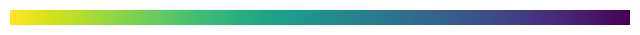

In [ ]:
cm.plot_colormap('viridis_r',
                 width=8.0, height=0.2, orientation='horizontal')

In [ ]:
# 서식지 적합성 지도(Habitat suitability map)
images = ee.List.sequence(
    0, ee.Number(numiter).multiply(4).subtract(1), 4).\
    map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {
    'min': 0,
    'max': 1,
    'palette': cm.palettes.viridis_r}
Map.addLayer(ModelAverage, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability",
                 orientation="horizontal",
                 layer_name="Habitat suitability")
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# 잠재 분포 지도(Potential distribution map)
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).\
                           subtract(1), 4).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution",
                 discrete=True, orientation="horizontal",
                 layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.533064630393035, 126.8858638222748], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.6. 정확도 평가 및 변수 중요도

Random Forest(ee.Classifier.smileRandomForest)는 앙상블 학습 방법 중 하나로, 여러 개의 의사 결정 트리(decision tree)를 구성하여 예측을 수행하는 방법입니다. 각 의사 결정 트리는 데이터의 서로 다른 부분 집합을 기반으로 독립적으로 학습하며, 그 결과를 종합하여 더 정확하고 안정적인 예측을 가능하게 합니다.

변수 중요도(variable importance)란 Random Forest 모델 내에서 어떤 변수가 예측에 영향을 많이 미치는지를 평가하는 지표입니다. 앞서 정의된 SDM() 함수에서 ClassifierPr 변수는 확률 모드로 훈련된 Random Forest 분류기입니다. 이 변수를 추가 리턴해서 변수 중요도를 계산해 보겠습니다.

In [ ]:
# 각 변수 중요도 값을 리스트로 추출
variables = [item[0] for item in importances_list]
importances = [item[1] for item in importances_list]

# 변수 중요도 평균 계산
average_importances = {}
for variable in set(variables):
    indices = [i for i, var in enumerate(variables) if var == variable]
    average_importance = np.mean([importances[i] for i in indices])
    average_importances[variable] = average_importance

# 평균 변수 중요도 출력
for variable, avg_importance in average_importances.items():
    print(f"{variable}: {avg_importance}")

bio14: 13.255003707499139
TCC: 22.246996114947372
slope: 9.901137700281456
elevation: 52.97146901087349
aspect: 3.7300740345496726
bio09: 24.669916904235823


평균 변수 중요도를 시각화하여, 변수 중요도가 높은 순으로 정렬된 막대 그래프를 생성합니다. 각 막대 위에 해당 변수의 평균 중요도 값을 표시하여 변수 간의 상대적 중요도를 시각적으로 비교할 수 있습니다.

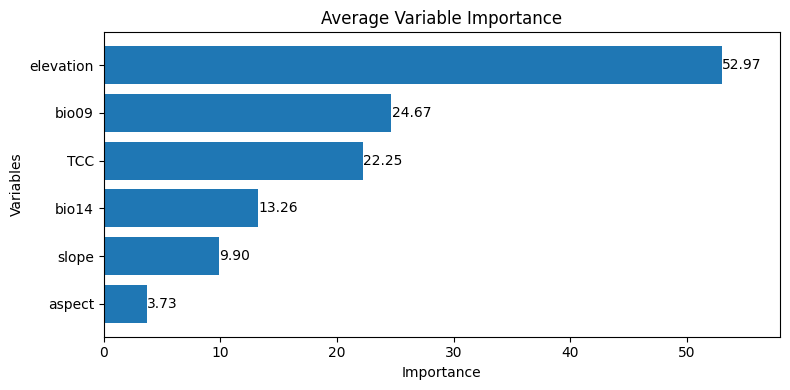

In [ ]:
# 변수 중요도가 높은 순으로 정렬
sorted_importances = sorted(average_importances.items(),
                            key=lambda x: x[1], reverse=False)
variables = [item[0] for item in sorted_importances]
avg_importances = [item[1] for item in sorted_importances]

# 그래프 크기 조절
plt.figure(figsize=(8, 4))  # 원하는 크기로 조절

# 막대그래프로 평균 중요도 출력
plt.barh(variables, avg_importances)
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.title('Average Variable Importance')

# 막대 위에 수치 표시
for i, v in enumerate(avg_importances):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')

# x축 범위 조정
plt.xlim(0, max(avg_importances) + 5)  # 원하는 범위로 조절

plt.tight_layout()
plt.savefig('variable_importance.png')
plt.show()

<p align="center"><img src="https://github.com/osgeokr/GEE-PAM-Book/blob/main/img/accuracy_assessment.png?raw=1" width = "800px"></img></p>

검증 데이터셋을 사용하여 각 실행에 대해 AUC-ROC와 AUC-PR를 계산합니다. 그런 다음 n번의 반복에 대해 평균 AUC-ROC 및 AUC-PR를 계산합니다.

* AUC-ROC는 "민감도(Sensitivity, = Recall) 대 1-특이도 (1-Specificity)" 그래프 아래의 면적으로, 임계값을 변화시켰을 때의 민감도와 특이도의 관계를 나타냅니다. 특이도는 모든 관측된 비출현에 기반합니다. 따라서 AUC-ROC는 혼동 행렬의 모든 사분면을 포함합니다.

* AUC-PR은 "정밀도(Precision) 대 재현율(Recall = Sensitivity)" 그래프 아래의 면적으로, 임계값을 변화시켰을 때의 정밀도와 재현율의 관계를 나타냅니다. 정밀도는 모든 예측된 출현에 기반합니다. 따라서, AUC-PR은 진음성(TN)의 수를 포함하지 않습니다.

각 실행에서 모델 검증에 충분한 지점 수가 있는지 확인하는 것이 중요합니다. 최종 지점 수는 공간 블록의 무작위 분할에 따라 달라지기 때문에 모델 검증에 충분한 출현 및 임의-비출현 지점이 있는지 확인해야 합니다.

멸종위기종이나 희귀종과 같은 경우, 출현 데이터가 부족하여 검증용 데이터셋 또한 부족할 수 있습니다. 이는 전문가들의 경험과 지식을 활용한 추가 데이터 수집 또는 관련 다른 데이터를 활용하는 대안이 필요합니다.

In [ ]:
def print_pres_abs_sizes(TestingDatasets, numiter):
    # 출현 및 임의-비출현 좌표가 충분한 지 체크 및 출력
    def get_pres_abs_size(x):
        fc = ee.FeatureCollection(TestingDatasets.get(x))
        presence_size = fc.filter(ee.Filter.eq('PresAbs', 1)).size()
        pseudo_absence_size = fc.filter(ee.Filter.eq('PresAbs', 0)).size()
        return ee.List([presence_size, pseudo_absence_size])

    sizes_info = ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(get_pres_abs_size).getInfo()

    for i, sizes in enumerate(sizes_info):
        presence_size = sizes[0]
        pseudo_absence_size = sizes[1]
        print(f'Iteration {i + 1}: Presence Size = {presence_size}, Pseudo-absence Size = {pseudo_absence_size}')

In [ ]:
# 검증용 데이터셋 추출
TestingDatasets = (ee.List.sequence(3, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x)))

print_pres_abs_sizes(TestingDatasets, numiter)

Iteration 1: Presence Size = 41, Pseudo-absence Size = 39
Iteration 2: Presence Size = 43, Pseudo-absence Size = 29
Iteration 3: Presence Size = 25, Pseudo-absence Size = 20
Iteration 4: Presence Size = 23, Pseudo-absence Size = 19
Iteration 5: Presence Size = 26, Pseudo-absence Size = 21
Iteration 6: Presence Size = 51, Pseudo-absence Size = 31
Iteration 7: Presence Size = 21, Pseudo-absence Size = 21
Iteration 8: Presence Size = 11, Pseudo-absence Size = 11
Iteration 9: Presence Size = 37, Pseudo-absence Size = 16
Iteration 10: Presence Size = 44, Pseudo-absence Size = 28


In [ ]:
def getAcc(HSM, TData, GrainSize):
    Pr_Prob_Vals = HSM.sampleRegions(collection=TData, properties=['PresAbs'], scale=GrainSize, tileScale=16)
    seq = ee.List.sequence(start=0, end=1, count=25) # Divide 0 to 1 into 25 intervals
    def calculate_metrics(cutoff):
        # Each element of the seq list is passed as cutoff(threshold value)

        # Observed present = TP + FN
        Pres = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 1)

        # TP (True Positive)
        TP = ee.Number(Pres.filterMetadata('classification', 'greater_than', cutoff).size())

        # TPR (True Positive Rate) = Recall = Sensitivity = TP / (TP + FN) = TP / Observed present
        TPR = TP.divide(Pres.size())

        # Observed absent = FP + TN
        Abs = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 0)

        # FN (False Negative)
        FN = ee.Number(Pres.filterMetadata('classification', 'less_than', cutoff).size())

        # TNR (True Negative Rate) = Specificity = TN  / (FP + TN) = TN / Observed absent
        TN = ee.Number(Abs.filterMetadata('classification', 'less_than', cutoff).size())
        TNR = TN.divide(Abs.size())

        # FP (False Positive)
        FP = ee.Number(Abs.filterMetadata('classification', 'greater_than', cutoff).size())

        # FPR (False Positive Rate) = FP / (FP + TN) = FP / Observed absent
        FPR = FP.divide(Abs.size())

        # Precision = TP / (TP + FP) = TP / Predicted present
        Precision = TP.divide(TP.add(FP))

        # SUMSS = SUM of Sensitivity and Specificity
        SUMSS = TPR.add(TNR)

        return ee.Feature(
            None,
            {
                'cutoff': cutoff,
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TPR': TPR,
                'TNR': TNR,
                'FPR': FPR,
                'Precision': Precision,
                'SUMSS': SUMSS
            }
        )

    return ee.FeatureCollection(seq.map(calculate_metrics))

In [ ]:
def calculate_and_print_auc_metrics(images, TestingDatasets, GrainSize, numiter):
    # AUC-ROC와 AUC-PR 계산
    def calculate_auc_metrics(x):
        HSM = ee.Image(images.get(x))
        TData = ee.FeatureCollection(TestingDatasets.get(x))
        Acc = getAcc(HSM, TData, GrainSize)

        # AUC-ROC 계산
        X = ee.Array(Acc.aggregate_array('FPR'))
        Y = ee.Array(Acc.aggregate_array('TPR'))
        X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
        Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
        auc_roc = X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

        # AUC-PR 계산
        X = ee.Array(Acc.aggregate_array('TPR'))
        Y = ee.Array(Acc.aggregate_array('Precision'))
        X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
        Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
        auc_pr = X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

        return (auc_roc, auc_pr)

    auc_metrics = ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(calculate_auc_metrics).getInfo()

    # 각 반복마다 AUC-ROC와 AUC-PR 출력
    df = pd.DataFrame(auc_metrics, columns=['AUC-ROC', 'AUC-PR'])
    df.index = [f'Iteration {i + 1}' for i in range(len(df))]
    df.to_csv('auc_metrics.csv', index_label='Iteration')
    print(df)

    # AUC-ROC와 AUC-PR의 평균과 표준편차 계산
    mean_auc_roc, std_auc_roc = df['AUC-ROC'].mean(), df['AUC-ROC'].std()
    mean_auc_pr, std_auc_pr = df['AUC-PR'].mean(), df['AUC-PR'].std()
    print(f'Mean AUC-ROC = {mean_auc_roc:.4f} ± {std_auc_roc:.4f}')
    print(f'Mean AUC-PR = {mean_auc_pr:.4f} ± {std_auc_pr:.4f}')

In [ ]:
%%time

# AUC-ROC와 AUC-PR 계산
calculate_and_print_auc_metrics(images, TestingDatasets, GrainSize, numiter)

               AUC-ROC    AUC-PR
Iteration 1   0.788124  0.782307
Iteration 2   0.896045  0.850443
Iteration 3   0.867105  0.718888
Iteration 4   0.971178  0.927846
Iteration 5   0.743056  0.753519
Iteration 6   0.800000  0.865801
Iteration 7   0.701754  0.688511
Iteration 8   0.792929  0.691343
Iteration 9   0.920202  0.920503
Iteration 10  0.868243  0.740146
Mean AUC-ROC = 0.8349 ± 0.0837
Mean AUC-PR = 0.7939 ± 0.0908
CPU times: user 1.96 s, sys: 150 ms, total: 2.11 s
Wall time: 2min 49s


In [ ]:
def calculate_and_print_ss_metrics(images, TestingDatasets, GrainSize, numiter):
    # 민감도(Sensitivity)와 특이도(Specificity) 계산
    def calculate_ss_metrics(x):
        HSM = ee.Image(images.get(x))
        TData = ee.FeatureCollection(TestingDatasets.get(x))
        Acc = getAcc(HSM, TData, GrainSize)

        # 민감도(Sensitivity) 계산
        sensitivity = Acc.sort('SUMSS', False).first().get('TPR')

        # 특이도(Specificity) 계산
        specificity = Acc.sort('SUMSS', False).first().get('TNR')

        return (sensitivity, specificity)

    ss_metrics = ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(calculate_ss_metrics).getInfo()

    # 각 반복마다 민감도와 특이도 출력
    df = pd.DataFrame(ss_metrics, columns=['Sensitivity', 'Specificity'])
    df.index = [f'Iteration {i + 1}' for i in range(len(df))]
    df.to_csv('ss_metrics.csv', index_label='Iteration')
    print(df)

    # 민감도와 특이도의 평균과 표준편차 계산
    mean_sensitivity, std_sensitivity = df['Sensitivity'].mean(), df['Sensitivity'].std()
    mean_specificity, std_specificity = df['Specificity'].mean(), df['Specificity'].std()
    print(f'Mean Sensitivity = {mean_sensitivity:.4f} ± {std_sensitivity:.4f}')
    print(f'Mean Specificity = {mean_specificity:.4f} ± {std_specificity:.4f}')

In [ ]:
%%time

# 민감도(sensitivity)와 특이도(specificity) 계산
# 민감도(sensitivity): 출현 예측의 정확성
# 특이도(specificity): 비출현 예측의 정확성
calculate_and_print_ss_metrics(images, TestingDatasets, GrainSize, numiter)

              Sensitivity  Specificity
Iteration 1      0.684211     0.743590
Iteration 2      0.911765     0.724138
Iteration 3      0.894737     0.750000
Iteration 4      0.857143     0.947368
Iteration 5      0.666667     0.857143
Iteration 6      0.767442     0.766667
Iteration 7      0.631579     0.714286
Iteration 8      0.666667     0.818182
Iteration 9      0.787879     0.933333
Iteration 10     0.837838     0.892857
Mean Sensitivity = 0.7706 ± 0.1033
Mean Specificity = 0.8148 ± 0.0878
CPU times: user 1.44 s, sys: 118 ms, total: 1.55 s
Wall time: 2min 50s


In [ ]:
def plot_roc_pr_curves(images, TestingDatasets, GrainSize, numiter):
    # Plot ROC and PR curves
    def get_roc_pr_values(x):
        HSM = ee.Image(images.get(x))
        TData = ee.FeatureCollection(TestingDatasets.get(x))
        Acc = getAcc(HSM, TData, GrainSize)

        # Get ROC and PR values
        varFPR = Acc.aggregate_array('FPR')
        varTPR = Acc.aggregate_array('TPR')
        varPrecision = Acc.aggregate_array('Precision')

        return (varFPR, varTPR, varPrecision)

    # Retrieve ROC and PR values for each iteration and model
    roc_pr_values = np.array(ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(get_roc_pr_values).getInfo())

    all_model_data = []
    for model_data in roc_pr_values:
        # Transpose data to match the desired format
        transposed_data = np.transpose(model_data)
        all_model_data.append(transposed_data)

    # Calculate mean and standard deviation across models
    mean_data = np.mean(all_model_data, axis=0)
    std_data = np.std(all_model_data, axis=0)

    # Create DataFrames for mean and standard deviation data
    df_mean = pd.DataFrame(mean_data, columns=['FPR', 'TPR', 'Precision'])
    df_std = pd.DataFrame(std_data, columns=['FPR', 'TPR', 'Precision'])

    # Set font size and style
    plt.rcParams.update({'font.size': 14})

    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot mean ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(df_mean['FPR'], df_mean['TPR'], color='blue', lw=2, label='Mean ROC Curve')
    plt.fill_between(df_mean['FPR'], df_mean['TPR'] - df_std['TPR'], df_mean['TPR'] + df_std['TPR'], color='gray', alpha=0.2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False positive rate (1 − specificity)')
    plt.ylabel('Sensitivity')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.grid(True)
    plt.legend(loc='lower right')

    # Plot mean PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(df_mean['TPR'], df_mean['Precision'], color='blue', lw=2, label='Mean PR Curve')
    plt.fill_between(df_mean['TPR'], df_mean['Precision'] - df_std['Precision'], df_mean['Precision'] + df_std['Precision'], color='gray', alpha=0.2)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('Recall (sensitivity)')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) curve')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_pr_curves_plot.png')
    plt.show()

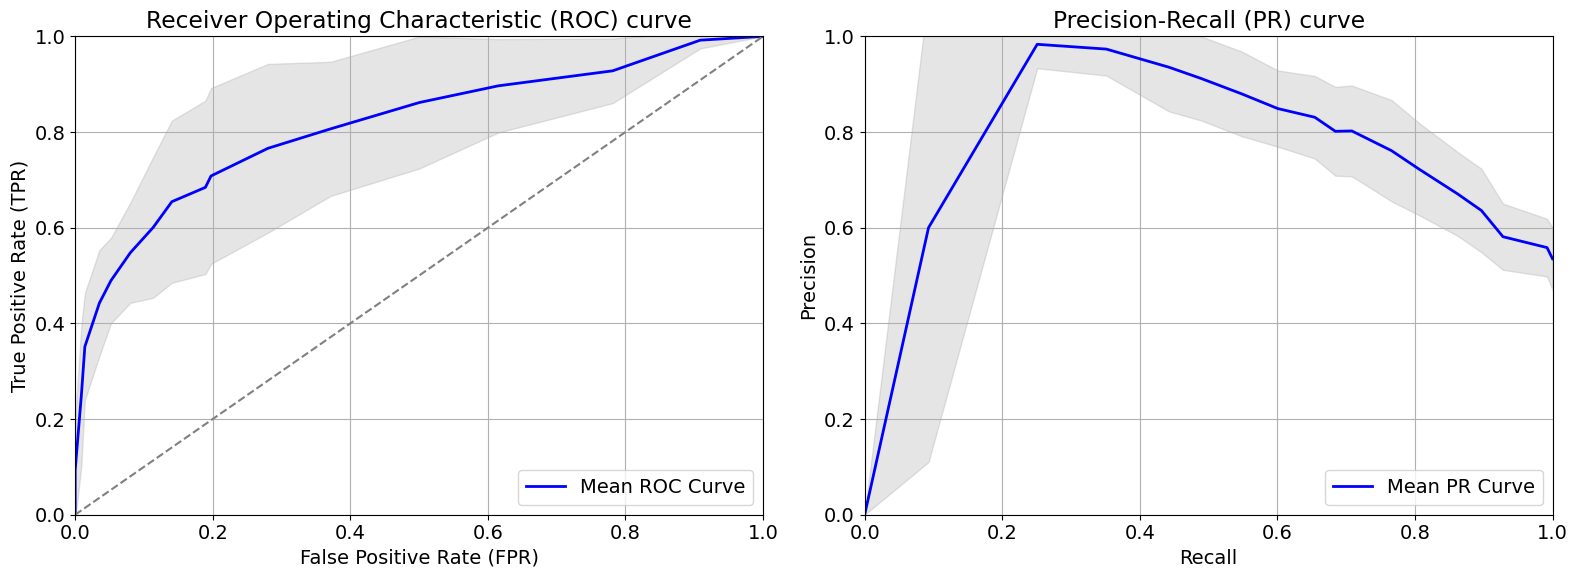

CPU times: user 2.19 s, sys: 335 ms, total: 2.52 s
Wall time: 2min 54s


In [ ]:
%%time

# ROC and PR 곡선 플롯
plot_roc_pr_curves(images, TestingDatasets, GrainSize, numiter)

In [ ]:
def create_DistributionMap2(images, TestingDatasets, GrainSize, numiter, ModelAverage):
    # Potential Distribution Map using the optimal threshold
    def get_metrics(x):
        HSM = ee.Image(images.get(x))
        TData = ee.FeatureCollection(TestingDatasets.get(x))
        Acc = getAcc(HSM, TData, GrainSize)
        return Acc.sort('SUMSS', False).first()

    metrics = ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(get_metrics)
    MeanThresh = ee.Number(ee.FeatureCollection(metrics).aggregate_array("cutoff").reduce(ee.Reducer.mean()))
    print('Mean threshold:', MeanThresh.getInfo())

    DistributionMap2 = ModelAverage.gte(MeanThresh)

    return DistributionMap2

In [ ]:
%%time

# Potential Distribution Map using the optimal threshold
DistributionMap2 = create_DistributionMap2(images, TestingDatasets, GrainSize, numiter, ModelAverage)

Mean threshold: 0.4625
CPU times: user 1.76 s, sys: 140 ms, total: 1.9 s
Wall time: 3min 1s


In [ ]:
%%time

# Custom Binary Distribution Mapping Based on Optimal Threshold
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)
Map.addLayer(DistributionMap2, vis_params, 'Potential distribution2')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution2", discrete=True, orientation="horizontal", layer_name="Potential distribution2")
Map.centerObject(Data.geometry(), 7)
Map

CPU times: user 1.4 s, sys: 209 ms, total: 1.61 s
Wall time: 2min 23s


Map(center=[35.533064630393035, 126.8858638222748], controls=(WidgetControl(options=['position', 'transparent_…

### 10. Export Results

In [ ]:
# Save the Habitat Suitability Map as a GeoTIFF
geemap.ee_export_image_to_drive(ModelAverage,
                                description='habitat_suitability',
                                folder='export',
                                region=AOI,
                                scale=100)

# Save the Potential Distribution Map as a GeoTIFF
geemap.ee_export_image_to_drive(DistributionMap,
                                description='distribution_map',
                                folder='export',
                                region=AOI,
                                scale=100)

# Save the Potential Distribution Map using the optimal threshold as a GeoTIFF
geemap.ee_export_image_to_drive(DistributionMap2,
                                description='distribution_map2',
                                folder='export',
                                region=AOI,
                                scale=100)